# Определение стоимости автомобилей

## Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## План работы

1.	Загрузим и подготовим данные.
2.	Обучим разные модели. Для каждой попробуйем различные гиперпараметры.
3.	Проанализируем скорость работы и качество моделей.

## Описание данных

Признаки:
-	`DateCrawled` — дата скачивания анкеты из базы
-	`VehicleType` — тип автомобильного кузова
-	`RegistrationYear` — год регистрации автомобиля
-	`Gearbox` — тип коробки передач
-	`Power` — мощность (л. с.)
-	`Model` — модель автомобиля
-	`Kilometer` — пробег (км)
-	`RegistrationMonth` — месяц регистрации автомобиля
-	`FuelType` — тип топлива
-	`Brand` — марка автомобиля
-	`Repaired` — была машина в ремонте или нет
-	`DateCreated` — дата создания анкеты
-	`NumberOfPictures` — количество фотографий автомобиля
-	`PostalCode` — почтовый индекс владельца анкеты (пользователя)
-	`LastSeen` — дата последней активности пользователя

Целевой признак:
-    `Price` — цена (евро)

Данные находятся в файле: `/datasets/autos.csv` 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Подготовка данных

In [4]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor, Pool
from catboost import CatBoostClassifier
from lightgbm import LGBMRegressor
import lightgbm
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [5]:
!pip install lightgbm

In [6]:
autos = pd.read_csv('/datasets/autos.csv')
display(autos.head(10).style.background_gradient(cmap='Blues', axis=0))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,nan,1993,manual,0,golf,150000,0,petrol,volkswagen,nan,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,nan,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,nan,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,nan,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,nan,volkswagen,nan,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


***Загрузили данные сервиса по продаже автомобилей с пробегом «Не бит, не крашен». Изучим их***

In [7]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [9]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [10]:
def bar_chart(file, column, title, xlabel, ylabel, bins):

    ax = file[column].plot(kind='hist', bins=bins, grid=False, color='blue', figsize=(16,8))
    ax.set_xlabel(xlabel, fontsize=16, fontweight="bold", color='blue')
    ax.set_ylabel(ylabel, fontsize=16, fontweight="bold", color='blue')
    ax.set_title(title, fontsize=16, fontweight="bold", color='blue')

None

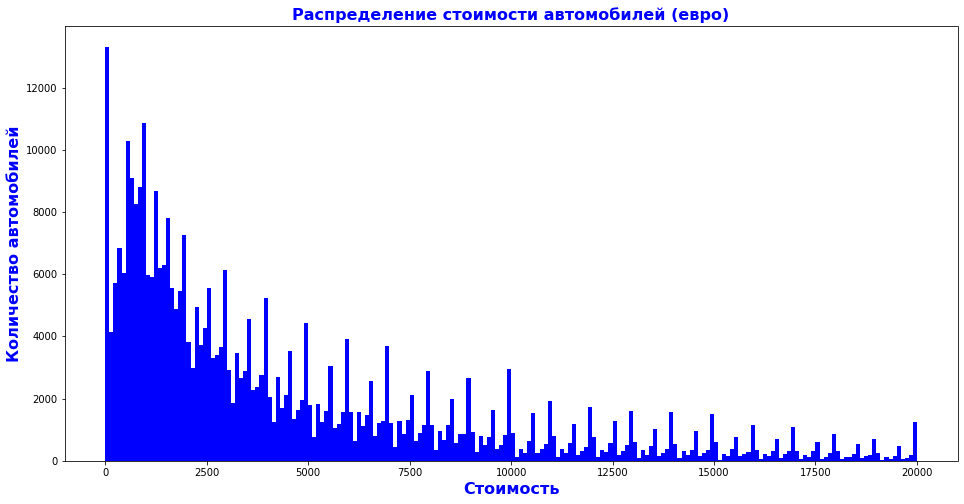

In [11]:
file=autos
column='Price'
title='Распределение стоимости автомобилей (евро)'
xlabel='Стоимость'
ylabel='Количество автомобилей'
bins=200
bar_chart(file, column, title, xlabel, ylabel, bins)

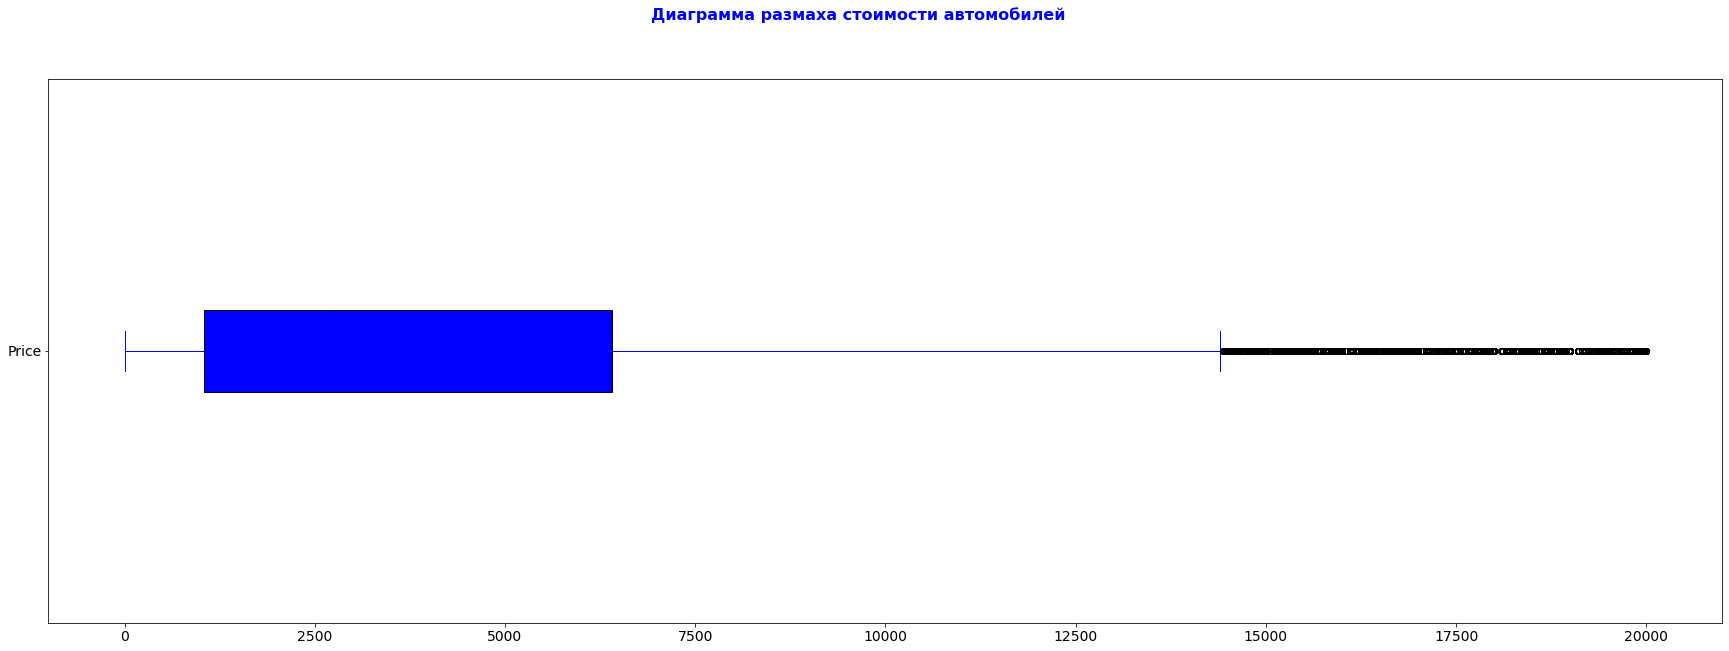

In [12]:
fig, axes = plt.subplots(figsize=(30, 10))
autos.boxplot(column=['Price'], vert=False, patch_artist = True, boxprops = dict(facecolor = "blue"), grid= False, fontsize=14, color='blue')
plt.suptitle(f'Диаграмма размаха стоимости автомобилей', fontsize=16, fontweight="bold", color='blue')
plt.show()

***Видим выбросы в данных по стоимости автомобилей и удалим  данные до квантили 0.05 и после 0.95***

In [13]:
autos['Price'].quantile([0.05, 0.95])

0.05      200.0
0.95    14600.0
Name: Price, dtype: float64

In [14]:
autos = autos.query('200 <= Price <= 14600')

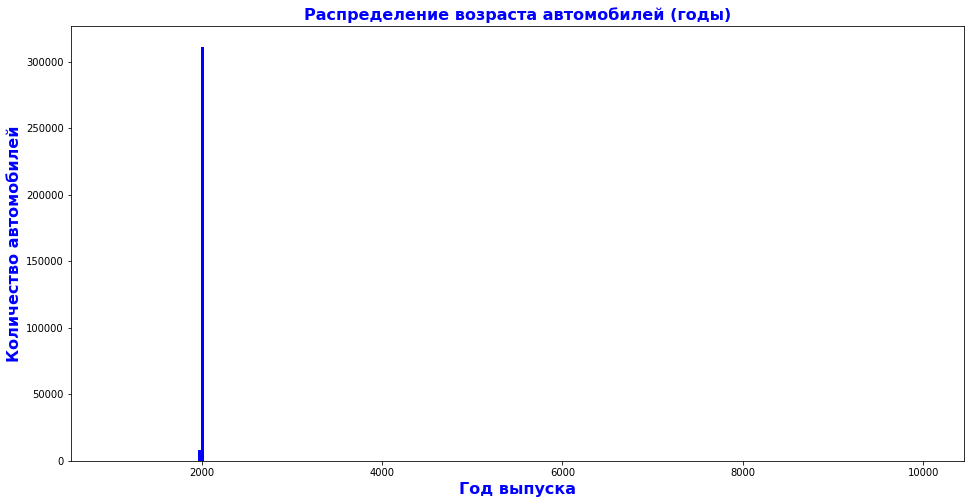

In [15]:
file=autos
column='RegistrationYear'
title='Распределение возраста автомобилей (годы)'
xlabel='Год выпуска'
ylabel='Количество автомобилей'
bins=300
bar_chart(file, column, title, xlabel, ylabel, bins)

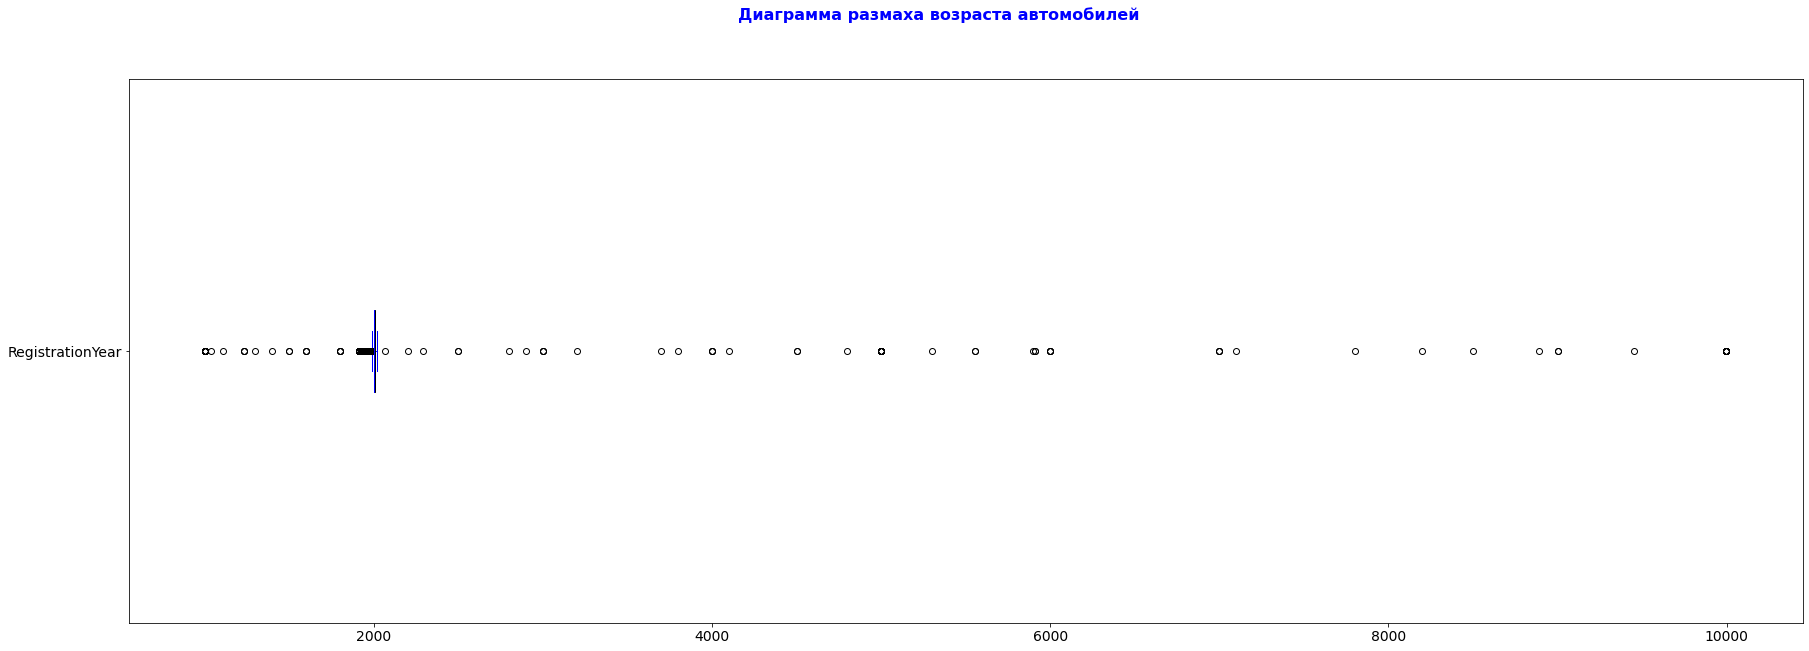

In [16]:
fig, axes = plt.subplots(figsize=(30, 10))
autos.boxplot(column=['RegistrationYear'], vert=False, patch_artist = True, boxprops = dict(facecolor = "blue"), grid= False, fontsize=14, color='blue')
plt.suptitle(f'Диаграмма размаха возраста автомобилей', fontsize=16, fontweight="bold", color='blue')
plt.show()

***Видим выбросы в данных по возрасту автомобилей и удалим  данные до квантили 0.05 и после 0.95***

In [17]:
autos['RegistrationYear'].quantile([0.05, 0.95])

0.05    1993.0
0.95    2016.0
Name: RegistrationYear, dtype: float64

In [18]:
autos = autos.query('1993 <= RegistrationYear <= 2016')

In [19]:
print(*autos['VehicleType'].unique(), sep='\n')

nan
suv
small
sedan
convertible
bus
wagon
coupe
other


In [20]:
autos.query('VehicleType != VehicleType')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07
35,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08 00:00:00,0,19386,2016-03-08 09:44:50
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354336,2016-03-05 18:57:45,3299,NaN,2005,auto,0,outlander,150000,4,petrol,mitsubishi,NaN,2016-03-05 00:00:00,0,17034,2016-03-06 04:17:37
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354351,2016-03-11 23:40:32,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11 00:00:00,0,87700,2016-03-12 14:16:51
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13


***Обноружили пропуски в данных типа кузова автомобилей `VehicleType`. Провели их заполнение по самому распространенному значению каждого бренда `Brand`***

In [21]:
spisok_df = autos.query('Brand == Brand')
spisok = spisok_df['Brand'].unique()
for element in spisok:
    df = autos.loc[autos['Brand'] == element]
    print(element,' - ',df['VehicleType'].value_counts().idxmax())
    autos.loc[(autos['Brand'] == element) & (autos['VehicleType'] != autos['VehicleType']), 'VehicleType'] = df['VehicleType'].value_counts().idxmax()

volkswagen  -  sedan
jeep  -  suv
skoda  -  wagon
bmw  -  sedan
peugeot  -  small
ford  -  small
mazda  -  sedan
renault  -  small
mercedes_benz  -  sedan
seat  -  small
honda  -  sedan
fiat  -  small
mini  -  small
smart  -  small
hyundai  -  small
opel  -  small
audi  -  wagon
nissan  -  small
alfa_romeo  -  sedan
subaru  -  wagon
volvo  -  wagon
mitsubishi  -  sedan
kia  -  small
lancia  -  small
citroen  -  small
sonstige_autos  -  suv
toyota  -  small
chevrolet  -  small
dacia  -  wagon
daihatsu  -  small
suzuki  -  small
chrysler  -  bus
daewoo  -  small
rover  -  sedan
porsche  -  suv
saab  -  sedan
jaguar  -  sedan
land_rover  -  suv
lada  -  suv
trabant  -  sedan


In [22]:
autos['VehicleType'].isnull().sum()

0

In [23]:
display(autos.loc[autos['Brand'] == 'sonstige_autos'])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
306,2016-03-21 14:38:37,200,suv,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,6493,2016-03-24 02:47:34
431,2016-03-20 20:45:27,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no,2016-03-20 00:00:00,0,90562,2016-04-03 04:17:08
661,2016-04-01 15:56:27,9900,suv,2000,auto,250,NaN,150000,4,lpg,sonstige_autos,no,2016-04-01 00:00:00,0,17309,2016-04-07 14:56:03
700,2016-03-30 21:37:21,6999,sedan,2010,auto,186,NaN,125000,4,petrol,sonstige_autos,no,2016-03-30 00:00:00,0,81929,2016-04-05 11:18:33
985,2016-03-15 16:37:22,500,sedan,2010,manual,101,NaN,70000,1,petrol,sonstige_autos,yes,2016-03-15 00:00:00,0,76829,2016-03-21 14:15:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353892,2016-03-06 11:42:12,7900,bus,2009,NaN,140,NaN,125000,7,gasoline,sonstige_autos,no,2016-03-06 00:00:00,0,97256,2016-03-26 16:16:02
354062,2016-03-19 11:25:16,6000,small,2008,manual,155,NaN,150000,5,petrol,sonstige_autos,no,2016-03-19 00:00:00,0,63069,2016-04-07 00:46:42
354073,2016-03-19 14:53:26,1750,suv,1995,NaN,0,NaN,100000,12,NaN,sonstige_autos,NaN,2016-03-19 00:00:00,0,6188,2016-04-01 01:47:17
354321,2016-03-15 13:52:34,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15 00:00:00,0,91186,2016-03-17 08:16:25


In [24]:
df = autos.loc[autos['Brand'] == 'sonstige_autos']
print(*df['Model'].unique(), sep='\n')

nan


***В данных бренда `Brand` под обозначением `sonstige_autos` (другой авто) отсутствует информация о модели автомобиля `Model`. Таким и заполним `no_info` отсутвующее значение***

In [25]:
autos.loc[autos['Brand'] == 'sonstige_autos', 'Model'] = 'no_info'

In [26]:
autos['Brand'].value_counts()

volkswagen        61416
opel              34001
bmw               29846
mercedes_benz     24781
audi              23321
ford              21276
renault           15512
peugeot            9947
fiat               8177
seat               5994
smart              4916
skoda              4907
mazda              4841
citroen            4449
nissan             4095
toyota             4089
hyundai            3176
volvo              2668
mitsubishi         2577
mini               2519
honda              2367
kia                2127
alfa_romeo         1960
suzuki             1949
sonstige_autos     1481
chevrolet          1342
chrysler           1216
dacia               844
daihatsu            687
subaru              622
daewoo              483
jeep                466
saab                439
rover               403
land_rover          380
lancia              378
jaguar              376
porsche             291
lada                167
trabant              13
Name: Brand, dtype: int64

***Обноружили пропуски в данных модели автомобилей `Model`. Провели их заполнение по самому распространенному значению каждого бренда `Brand`***

In [27]:
spisok_df = autos.query('Brand == Brand')
spisok = spisok_df['Brand'].unique()
for element in spisok:
    df = autos.loc[autos['Brand'] == element]
    df.dropna(subset=['Model'], inplace=True)
    print(element,' - ',df['Model'].value_counts().idxmax())
    autos.loc[((autos['Brand'] == element) & (autos['Model'] != autos['Model'])), 'Model'] = df['Model'].value_counts().idxmax()

volkswagen  -  golf
jeep  -  grand
skoda  -  fabia
bmw  -  3er
peugeot  -  2_reihe
ford  -  focus
mazda  -  6_reihe
renault  -  twingo
mercedes_benz  -  c_klasse
seat  -  ibiza
honda  -  civic
fiat  -  punto
mini  -  cooper
smart  -  fortwo
hyundai  -  i_reihe
opel  -  corsa
audi  -  a4
nissan  -  micra
alfa_romeo  -  156
subaru  -  impreza
volvo  -  v40
mitsubishi  -  colt
kia  -  other
lancia  -  ypsilon
citroen  -  other
sonstige_autos  -  no_info
toyota  -  yaris
chevrolet  -  other
dacia  -  logan
daihatsu  -  cuore
suzuki  -  other
chrysler  -  other
daewoo  -  matiz
rover  -  other
porsche  -  cayenne
saab  -  other
jaguar  -  x_type
land_rover  -  freelander
lada  -  niva
trabant  -  601


In [28]:
autos['Model'].isnull().sum()

0

In [29]:
print(*autos['Gearbox'].unique(), sep='\n')

manual
auto
nan


***В данных о типе коробки передача `Gearbox` присутствуют пропуски. Заполним `no_info` отсутвующее значение о типе коробки передач***

In [30]:
autos['Gearbox'] = autos['Gearbox'].fillna('no_info')
None

In [31]:
print(*autos['FuelType'].unique(), sep='\n')

petrol
gasoline
nan
lpg
other
hybrid
cng
electric


***В данных о типе топлива `FuelType` присутствуют пропуски. Заполним `no_info` отсутвующее значение о типе топлива автомобиля***

In [32]:
autos['FuelType'] = autos['FuelType'].fillna('no_info')

In [33]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired             51218
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [34]:
print(*autos['Repaired'].unique(), sep='\n')

nan
no
yes


***В данных о ремонте автомобиля `Repaired` присутствуют пропуски. Заполним `no_info` отсутвующее значение о ремонте автомобиля***

In [35]:
autos['Repaired'] = autos['Repaired'].fillna('no_info')
None

In [36]:
print(*autos['Repaired'].unique(), sep='\n')

no_info
no
yes


In [37]:
def diagram(file, column, title, xlabel, ylabel):
    all = len(file)
    file_groupby = file.groupby(column).size()/all
    file_groupby_sort = file_groupby.sort_values()
    mm = file_groupby_sort.plot(kind='barh', color='blue', figsize=(26,8))
    plt.title(f'{title}', fontsize=16, fontweight="bold", color='blue')
    plt.xlabel(f'{xlabel}', fontsize=16, fontweight="bold", color='blue')
    plt.ylabel(f'{ylabel}', fontsize=16, fontweight="bold", color='blue')

    percent = dict(file_groupby_sort)
    row = 0
    i = 0
    for row in percent:
        mm.text(percent[row]-0.09+0.09, i, str(round(percent[row]*100, 2)) + '%',
                      fontsize = 'large', fontweight='bold', color='blue')
        i += 1

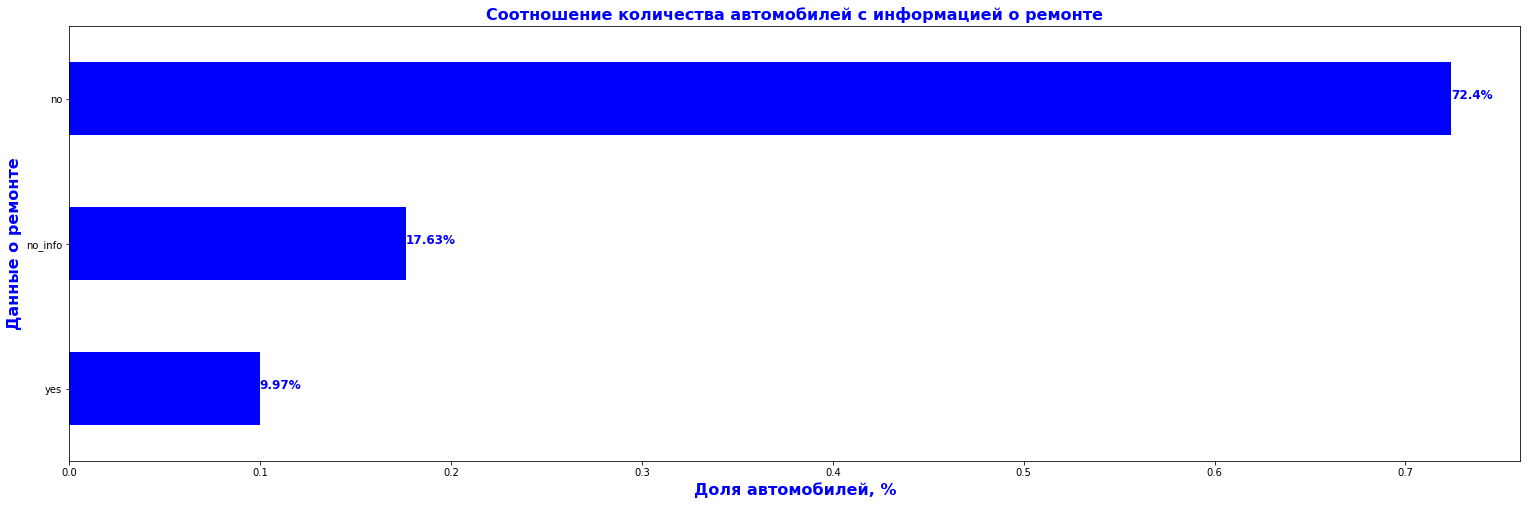

In [38]:
file=autos
column='Repaired'
title='Соотношение количества автомобилей с информацией о ремонте'
xlabel='Доля автомобилей, %'
ylabel='Данные о ремонте'
diagram(file, column, title, xlabel, ylabel)

In [39]:
autos.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [40]:
autos.duplicated().sum()

4

In [41]:
autos[autos.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


***Обнаружили дубликаты в данных. Удалим их***

In [42]:
autos = autos.drop_duplicates()
autos.duplicated().sum()

0

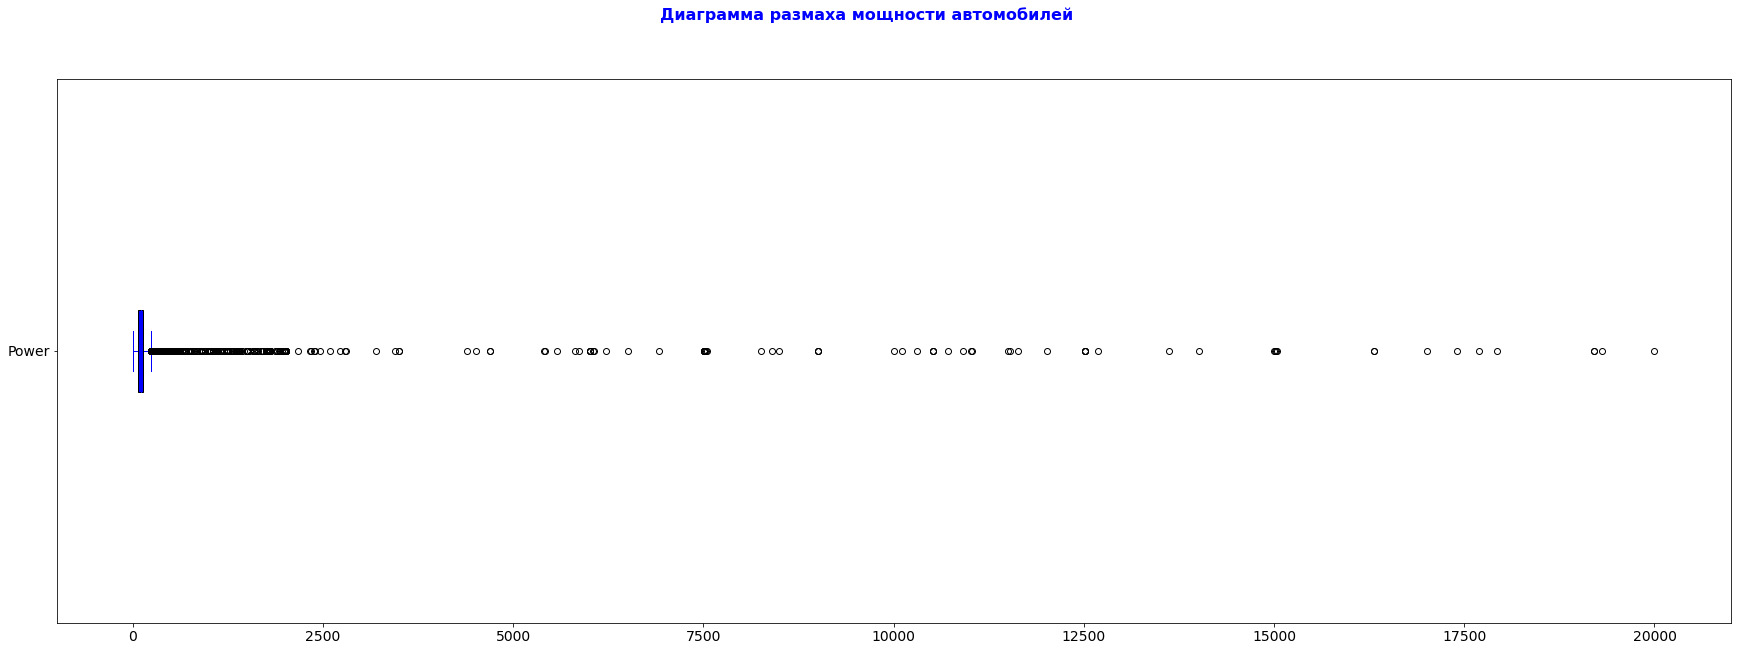

In [43]:
fig, axes = plt.subplots(figsize=(30, 10))
autos.boxplot(column=['Power'], vert=False, patch_artist = True, boxprops = dict(facecolor = "blue"), grid= False, fontsize=14, color='blue')
plt.suptitle(f'Диаграмма размаха мощности автомобилей', fontsize=16, fontweight="bold", color='blue')
plt.show()

***Видим выбросы в данных по мощности автомобилей и удалим  данные до квантили 0.05 и после 0.95***

In [44]:
autos['Power'].quantile([0.05, 0.95])

0.05      0.0
0.95    204.0
Name: Power, dtype: float64

***По имеющейся информации об автомобильных двигателях, исключим автомобили с мощностью менее 20 лошадиных сил. https://quto.ru/journal/articles/top-avtomobiley-s-samymi-kroshechnymi-motorami.htm***

In [45]:
autos = autos.query('20 <= Power <= 204')

In [46]:
autos['Power'].describe()

count    248663.000000
mean        110.461022
std          38.844643
min          20.000000
25%          75.000000
50%         105.000000
75%         140.000000
max         204.000000
Name: Power, dtype: float64

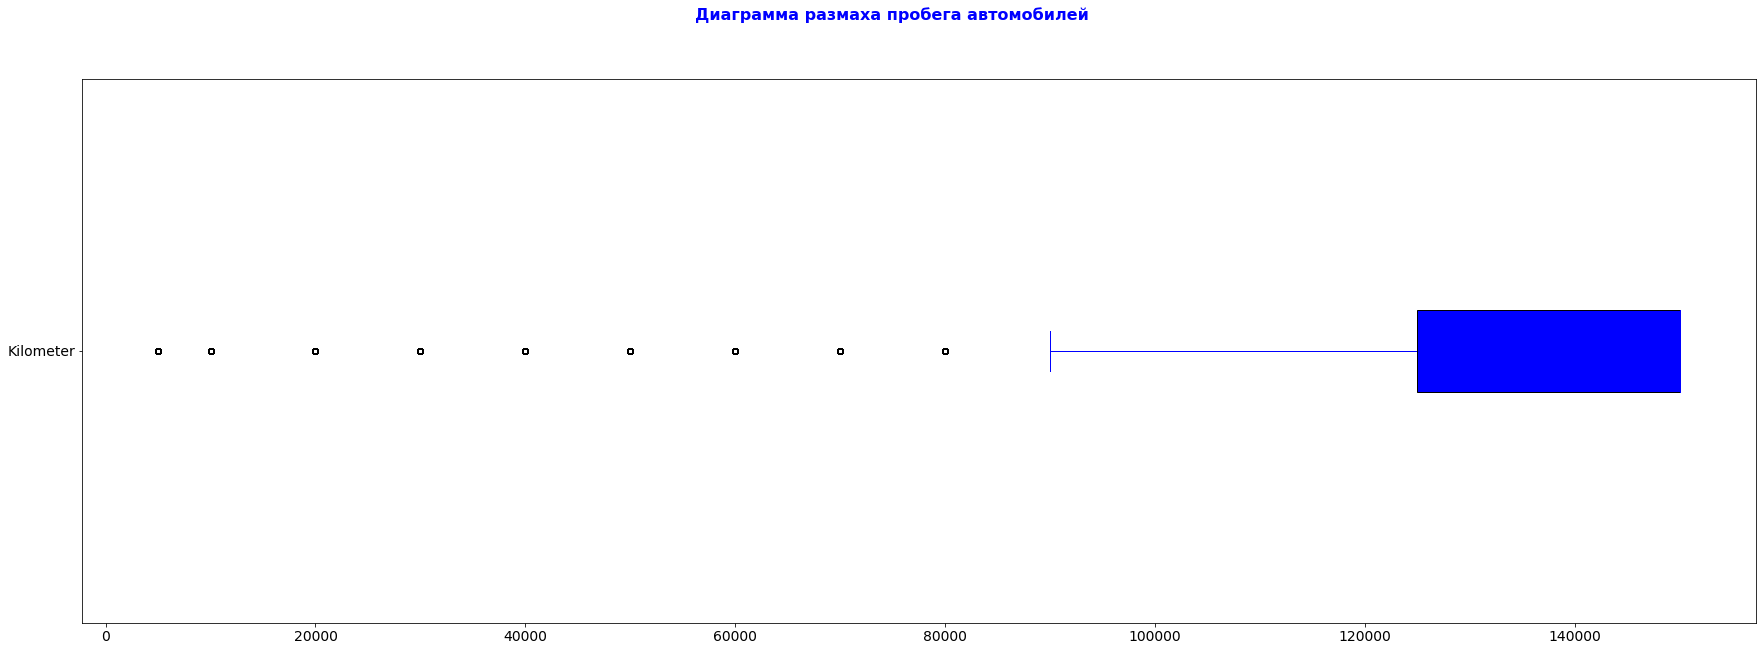

In [47]:
fig, axes = plt.subplots(figsize=(30, 10))
autos.boxplot(column=['Kilometer'], vert=False, patch_artist = True, boxprops = dict(facecolor = "blue"), grid= False, fontsize=14, color='blue')
plt.suptitle(f'Диаграмма размаха пробега автомобилей', fontsize=16, fontweight="bold", color='blue')
plt.show()

***Видим выбросы в данных по пробегу автомобилей и удалим  данные до квантили 0.05 и после 0.95***

In [48]:
autos['Kilometer'].quantile([0.05, 0.95])

0.05     50000.0
0.95    150000.0
Name: Kilometer, dtype: float64

In [49]:
autos = autos.query('50000 <= Kilometer <= 150000')

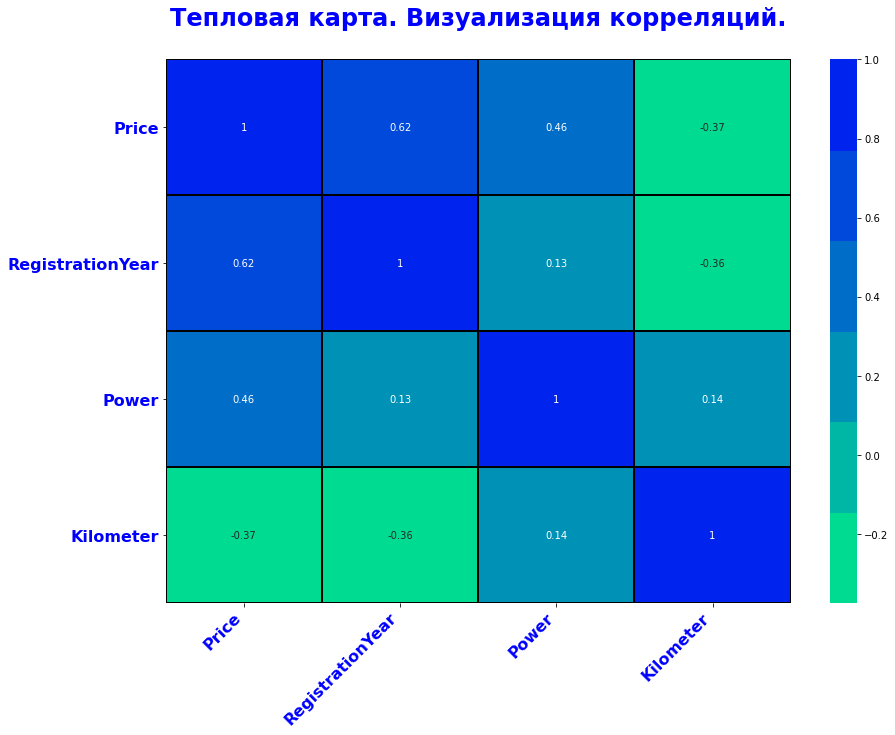

In [50]:
file = autos.loc[:, ['Price', 'RegistrationYear', 'Power', 'Kilometer']]
plt.figure(figsize=(14,10))
colormap = sns.color_palette("winter_r")
chart = sns.heatmap(file.corr(), annot=True, cmap=colormap, linewidths=1, linecolor='black')
plt.title('Тепловая карта. Визуализация корреляций.\n ', fontsize=24, fontweight="bold", color='blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16, fontweight="bold", color='blue')
chart.set_yticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right', fontsize=16, fontweight="bold", color='blue')
plt.show()

***Провели корреляционный анализ и обнаружили слабую связь (-0.37) целевого признака `Price` с пробегом `Kilometer` и с мощностью двигателя (0.46) `Power`. Связь целевого признака с возрастом автомобиля `RegistrationYear` средняя (0.62)***

## Обучение моделей

***`Price` является целевым признаком для построения модели при определения стоимости автомобиля.***

***Среди признаков имеются неинформативные, которые не влияют на предсказания цены. Такие признаки, как `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`, следует удалить.***

In [51]:
drop_features = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
autos = autos.drop(columns=drop_features)

In [52]:
all_features = ['RegistrationYear', 'Power', 'Kilometer', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']  
num_features = ['RegistrationYear', 'Power', 'Kilometer']

### Линейная регрессия

In [53]:
X = autos[all_features]
y = autos['Price']

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)

In [54]:
encoder_ohe = OneHotEncoder(drop='first',  handle_unknown='ignore', sparse_output=False)

encoder_ohe.fit(X_train[cat_features])

X_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_train[cat_features])

X_train = X_train.drop(cat_features, axis=1)

X_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_test[cat_features])

X_test = X_test.drop(cat_features, axis=1)

X_train.shape, X_test.shape

((142774, 299), (95184, 299))

In [55]:
start = time.time() 
model = LinearRegression()
model.fit(X_train, y_train)
training_time_l = time.time() - start
print('\u001b[38;5;19m','Время обучения = ', round(training_time_l, 4), '\u001b[0m')

 Время обучения =  11.5262 


In [56]:
start = time.time()  
y_pred = model.predict(X_train)
predict_time_l = time.time() - start
print('\u001b[38;5;19m','Время предсказания  = ', round(predict_time_l, 4), '\u001b[0m')

 Время предсказания  =  0.228 


In [57]:
rmse_l = mean_squared_error(y_train, y_pred, squared = False)
print('\u001b[38;5;19m','RMSE = ', round(rmse_l, 2), '\u001b[0m')

 RMSE =  1757.58 


### Модель CatBoost

In [58]:
X = autos[all_features]
y = autos['Price']

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

encoder.fit(X_train[cat_features])

X_train[cat_features] = encoder.transform(X_train[cat_features])

X_test[cat_features] = encoder.transform(X_test[cat_features])

X_train.shape, X_test.shape

((142774, 9), (95184, 9))

In [59]:
model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[0.2, 0.25, 0.3, 0.35, 0.4], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(X_train, y_train)

print('\u001b[38;5;19m', gscv.best_params_, '\u001b[0m')

 {'learning_rate': 0.3, 'random_state': 12345, 'verbose': False} 


In [60]:
start = time.time()
model_cbr = CatBoostRegressor(learning_rate=0.3, random_state=12345, verbose=False)
model_cbr.fit(X_train, y_train)
training_time_cbr = time.time() - start
print('\u001b[38;5;19m','Время обучения = ', round(training_time_cbr, 4), '\u001b[0m')

 Время обучения =  17.5789 


In [61]:
start = time.time()
y_pred = model_cbr.predict(X_train)
predict_time_cbr = time.time() - start
print('\u001b[38;5;19m','Время предсказания  = ', round(predict_time_cbr, 4), '\u001b[0m')

 Время предсказания  =  0.1252 


In [62]:
rmse_cbr = mean_squared_error(y_train, y_pred, squared = False)
print('\u001b[38;5;19m','RMSE = ', round(rmse_cbr, 2), '\u001b[0m')

 RMSE =  1040.31 


###  Light Gradient Boosted Machine (LightGBM)

In [63]:
start = time.time()
model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[160, 170, 180], 'learning_rate':[0.1, 0.15, 0.2, 0.25, 0.3], 'random_state':[12345]}]

clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

print('\u001b[38;5;19m', clf.best_params_, '\u001b[0m')

 {'learning_rate': 0.2, 'num_leaves': 170, 'random_state': 12345} 


In [64]:
start = time.time()
model_lgbmr = LGBMRegressor(learning_rate=0.2, num_leaves=170, random_state=12345)
model_lgbmr.fit(X_train, y_train)
training_time_lgbmr = time.time() - start
print('\u001b[38;5;19m','Время обучения = ', round(training_time_lgbmr, 4), '\u001b[0m')

 Время обучения =  9.0906 


In [65]:
start = time.time()
y_pred = model_lgbmr.predict(X_train)
predict_time_lgbmr = time.time() - start
print('\u001b[38;5;19m','Время предсказания  = ', round(predict_time_lgbmr, 4), '\u001b[0m')

 Время предсказания  =  1.1044 


In [66]:
rmse_lgbmr = mean_squared_error(y_train, y_pred, squared = False)
print('\u001b[38;5;19m','RMSE = ', round(rmse_lgbmr, 2), '\u001b[0m')

 RMSE =  1019.66 


## Анализ моделей

***Определим сравнение изученных моделей введя столбец с рейтингом. Учтем равнозначность параметров по времени обучения модели, времени предсказания модели и RMSE. Введем коэффициенты учитывыающие вес данных зависящий от порядка численного значения.***

In [67]:
data = {'Время обучения модели':[training_time_l, training_time_cbr, training_time_lgbmr],
        'Время предсказания модели':[predict_time_l, predict_time_cbr, predict_time_lgbmr],
        'RMSE обучения':[rmse_l, rmse_cbr, rmse_lgbmr]}

index = ['LinearRegression', 'CatBoostRegressor', 'LGBMRegressor',]

data_final = pd.DataFrame(data=data, index=index)

data_final['Рейтинг модели'] = (data_final['Время обучения модели'] * 0.33/10 + data_final['Время предсказания модели'] * 0.33 + data_final['RMSE обучения'] * 0.34/1000)

display(data_final.sort_values(by='Рейтинг модели', ascending=True).style.background_gradient(cmap='Blues', axis=0))

,Время обучения модели,Время предсказания модели,RMSE обучения,Рейтинг модели
CatBoostRegressor,17.578889,0.125180,1040.312831,0.975119
LGBMRegressor,9.090593,1.104414,1019.657027,1.011130
LinearRegression,11.526179,0.227985,1757.584192,1.053178


***У моделей `CatBoost` и `LightGBM` можно сказать близкий результат по `RMSE`. Но у `LightGBM` почти в 2 раза быстрее время обучения. А у `CatBoost` в 9 раз быстрее время предсказания модели. Модель `CatBoost` оказалась более подходящая согласно минимального значения введенного рейтинга.***

In [68]:
start = time.time()
y_pred = model_cbr.predict(X_test)
predict_time_cbr = time.time() - start
print('\u001b[38;5;19m','Время предсказания  = ', round(predict_time_cbr, 4), '\u001b[0m')

 Время предсказания  =  0.1 


In [69]:
rmse_cbr = mean_squared_error(y_test, y_pred, squared = False)
print('\u001b[38;5;19m','RMSE = ', round(rmse_cbr, 2), '\u001b[0m')

 RMSE =  1138.95 


In [70]:
data = {'Время обучения модели':[training_time_cbr],
        'Время предсказания модели':[ predict_time_cbr],
        'RMSE обучения':[rmse_cbr]}

index = ['CatBoostRegressor']

data_final = pd.DataFrame(data=data, index=index)

display(data_final.style.background_gradient(cmap='Blues', axis=0))

,Время обучения модели,Время предсказания модели,RMSE обучения
CatBoostRegressor,17.578889,0.099979,1138.952577


## Выводы:

- Загрузили и изучили данные сервиса по продаже автомобилей с пробегом «Не бит, не крашен»
- Обноружили пропуски в данных `Model` и `VehicleType`. Провели их заполнение по самому распространенному значению каждого бренда `Brand`
- Обноружили пропуски в данных провели их заполнение и по необходимости удаление
- Обноружили аномальные значения в данных провели по необходимости удаление
- Обнаружили дубликаты и удалили их
- Провели корреляционный анализ и обнаружили слабую связь (-0.37) целевого признака `Price` с пробегом `Kilometer` и с мощностью двигателя (0.46) `Power`. Связь целевого признака с возрастом автомобиля `RegistrationYear` средняя (0.62) 
- Создали  3 модели с разными гиперпараметрами (модель линейной регрессии, модель `CatBoost` и `LightGBM`). Все модели соответсвовали показателю `RMSE`<2500.
- Провели анализ полученных результатов для выбора лучшей модели по соотношению время/качество, основываясь на обучающей выборке. Лучшей показала себя модель CatBoost. На тестовой выборке она показала результат `RMSE` = 1139